# Jordan's COVID Stock Quick Analyzer

input the stock symbol in the box below and then run the rest of the code for a quick analysis of the stock and how COVID-19 has affected it vs the market.

## Input Symbol Below

In [1]:
symbol = 'AAPL'

## Now all you have to do is run the rest of the code!

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from matplotlib.ticker import FuncFormatter
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
NASDAQ = yf.Ticker("^IXIC").history(period="2y")
NASDAQ['date'] = NASDAQ.index
NASDAQ = NASDAQ.reset_index(drop=True)

In [4]:
name = yf.Ticker(symbol)
data = name.history(period="2y")
data['date'] = data.index
data = data.reset_index(drop=True)

In [5]:
def stock_info(stock_data):
    df1 = stock_data[len(stock_data[stock_data['date'] < '2020-02-11'])+1:]
    percent = round((df1['Close'].iloc[-1]/df1['Close'].iloc[0]-1)*100,2)
    print(f'Percent change since COVID-19 market tumble (February 12 2020) = {percent}%')

In [6]:
def pe_ratio(stock_name):
    print(f"The PE Ratio is: {round(stock_name.info['trailingPE'],2)}")

In [7]:
def prior(stock_data):
    mask1 = stock_data['date'] >= '2019-08-12'
    mask2 = stock_data['date'] <= '2020-02-12'
    dff = stock_data[mask1 & mask2]
    
    plt.figure(figsize=(8,5))
    plt.plot(dff['date'],dff['Close'])
    plt.tight_layout()
    plt.title("6 Months Prior to COVID-19 Market Effects")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid();

In [8]:
def comparison(stock_data,stock_symbol):
    mask1 = stock_data['date'] >= '2019-08-12'
    mask2 = stock_data['date'] <= pd.to_datetime('today')
    dff = stock_data[mask1 & mask2]
    dff2 = NASDAQ[mask1 & mask2]
    
    fig, ax = plt.subplots(1,figsize=(10,5))
    ax.plot(dff['date'],dff['Close']/dff['Close'].iloc[0]-1, label=stock_symbol)
    ax.plot(dff2['date'],dff2['Close']/dff2['Close'].iloc[0]-1, label='NASDAQ')
    ax.set(xlabel='Date', title=stock_symbol+' Compared to NASDAQ (^IXIC)')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
    ax.grid()
    plt.legend();

In [9]:
def recommend(stock_name):
    for i in range(3):
        date = str(name.recommendations.iloc[-3:].index[i].date())
        firm = name.recommendations.iloc[-3:]['Firm'][i]
        action = name.recommendations.iloc[-3:]['To Grade'][i]
        
        print(f'On {date}, {firm} recommended the stock as "{action}"')
    

In [10]:
def moving_average(stock_data, stock_symbol, period):
    stock_data['moving_av'] = stock_data['Close'].rolling(window=period).mean()

    fig, ax = plt.subplots(1,figsize=(10,5))
    ax.plot(stock_data['date'].tail(100),stock_data['moving_av'].tail(100), label= 'Moving Average')
    ax.plot(stock_data['date'].tail(100),stock_data['Close'].tail(100), label= stock_symbol)
    ax.set(xlabel='Date', title=stock_symbol + ' ' + str(period) + ' Day Moving Average')
    ax.grid()
    plt.legend();

Percent change since COVID-19 market tumble (February 12 2020) = -14.66%
The PE Ratio is: 22.17
On 2020-04-09, Nomura recommended the stock as "Neutral"
On 2020-04-13, Raymond James recommended the stock as "Outperform"
On 2020-04-16, Deutsche Bank recommended the stock as "Buy"


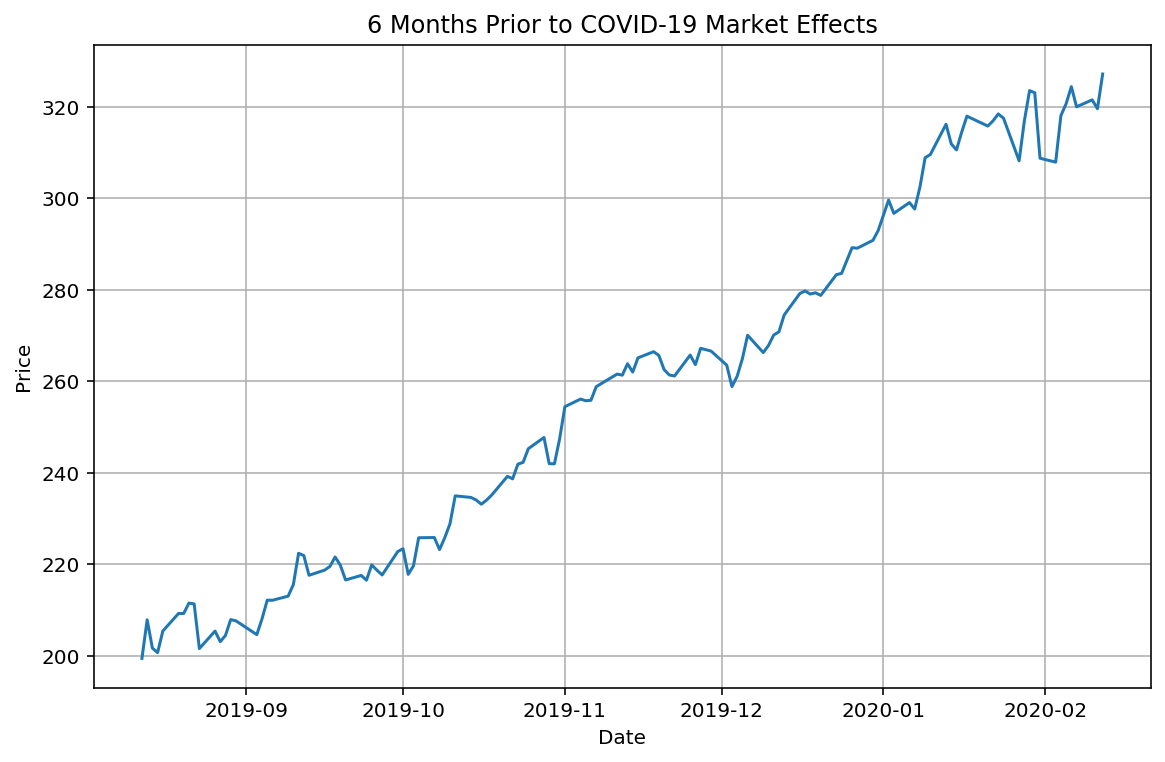

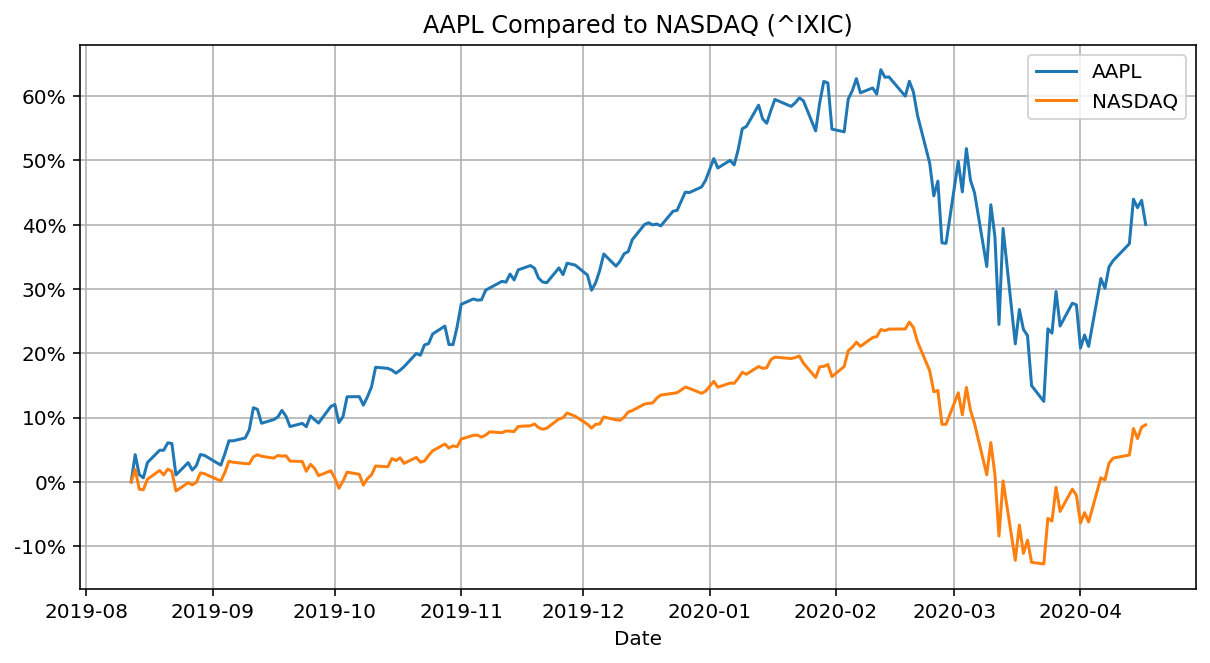

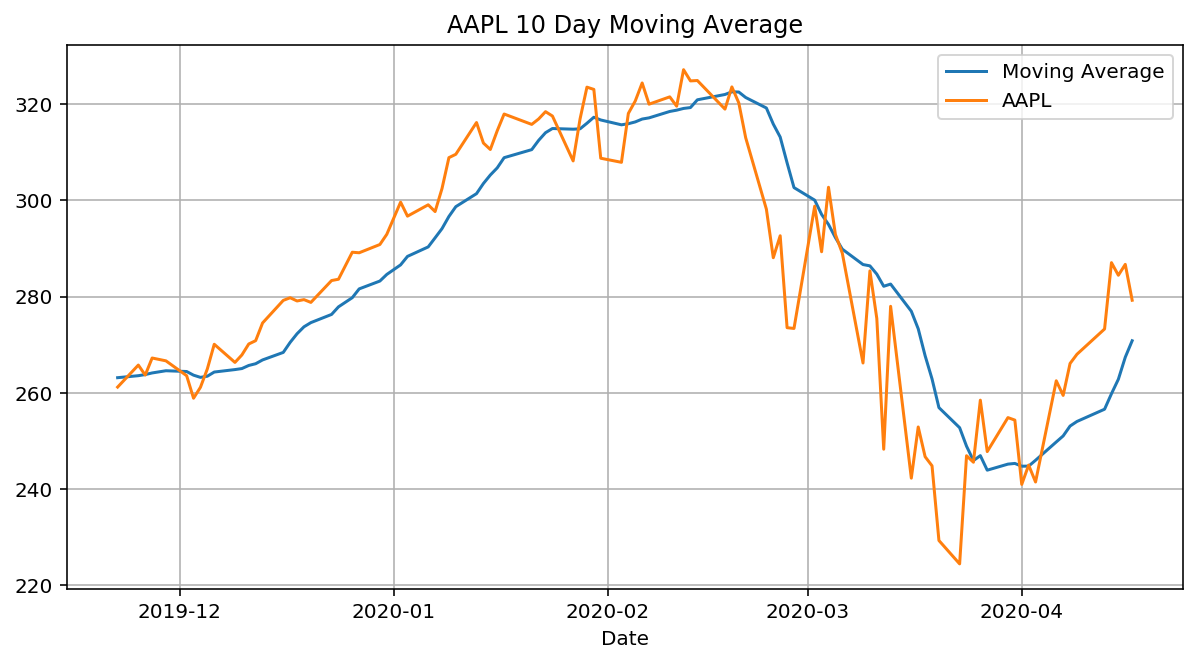

In [11]:
stock_info(data)
pe_ratio(name)
prior(data)
comparison(data, symbol)
recommend(name)
moving_average(data, symbol, 10)

## Using Altair (plotting software) to Create Interactive Charts

In [12]:
import altair as alt

In [27]:
def comparison_altair(stock_data,stock_symbol):
    mask1 = stock_data['date'] >= '2019-08-12'
    mask2 = stock_data['date'] <= pd.to_datetime('today')
    dff = stock_data[mask1 & mask2].copy(deep=True)
    dff2 = NASDAQ[mask1 & mask2].copy(deep=True)
    dff['stock'] = stock_symbol
    dff2['stock']='NASDAQ'
    dff['percent'] = round((dff['Close']/dff['Close'].iloc[0]-1)*100,2)
    dff2['percent'] = round((dff2['Close']/dff2['Close'].iloc[0]-1)*100,2)
    df = pd.concat([dff[['percent','stock','date']],dff2[['percent','stock','date']]])


    # Create a selection that chooses the nearest point & selects based on x-value
    nearest = alt.selection(type='single', nearest=True, on='mouseover',
                            fields=['date'], empty='none')

    # The basic line
    line = alt.Chart(df).mark_line(interpolate='basis').encode(
        x=alt.X('date', axis=alt.Axis(title='Date')),
        y=alt.Y('percent', axis=alt.Axis(title='Percent (%)')),
        color=alt.Color('stock', legend=alt.Legend(title="Stock"))
    )

    # Transparent selectors across the chart. This is what tells us
    # the x-value of the cursor
    selectors = alt.Chart(df).mark_point().encode(
        x='date',
        opacity=alt.value(0),
    ).add_selection(
        nearest
    )

    # Draw points on the line, and highlight based on selection
    points = line.mark_point().encode(
        opacity=alt.condition(nearest, alt.value(1), alt.value(0))
    )

    # Draw text labels near the points, and highlight based on selection
    text = line.mark_text(align='left', dx=5, dy=-10).encode(
        text=alt.condition(nearest, 'percent', alt.value(' '))
    )

    # Draw a rule at the location of the selection
    rules = alt.Chart(df).mark_rule(color='gray').encode(
        x='date',
    ).transform_filter(
        nearest
    )

    # Put the five layers into a chart and bind the data
    return alt.layer(
        line, selectors, points, rules, text
    ).properties(
        width=600, height=300
    ).interactive()


In [28]:
comparison_altair(data,symbol)

alt.LayerChart(...)